# Kaggle - Mpred
## Predicitive Maintenance Challenge
### https://www.kaggle.com/c/mpred-datascience-challenge
#### By: 55thSwiss


## Introduction

"A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant 
costs that are associated with delays in the production process due to mechanical problems. Most of these 
businesses are interested in predicting these problems in advance so that they can proactively prevent the 
problems before they occur which will reduce the costly impact caused by downtime.

The business problem for this example is about predicting problems caused by component failures such that 
the question “What is the probability that a machine will fail in the near future due to a failure of a 
certain component” can be answered. The problem is formatted as a multi-class classification problem and 
a machine learning algorithm is used to create the predictive model that learns from historical data collected 
from machines.

The goal is to predict when a given machine will fail within 24 hours due to a failure of a given component."

## Sources

Please refer to the predictive maintenance playbook [1] for a detailed explanation of common use cases 
in predictive maintenance and modelling approaches.

Original data set can be found at [2]

For methodology, we're going to more of less employ CRISP-DM [3] approach, and use generic decision tree to help pick the model type to try a few out [4].

[1] https://docs.microsoft.com/fr-fr/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

[2] https://www.kaggle.com/yuansaijie0604/xinjiang-pm/data

[3] https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining

[4] https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-cheat-sheet

## Problem Description

In this competition, the goal is to compute the probability that a machine will fail in 
the next 24 hours due to a specific component failure (component 1,2,3 or 4) hence you are asked to classify the 
observations into 5 categories : comp1, comp2,comp3,comp4 and none (e.g : The machine will fail due to 
component 1... 4 or will not fail in the next 24h). From a machine learning perspective this is called a multi-class classification problem.

## Data File Descriptions

__telemetry.csv__ The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015

__errors.csv__ The errors logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

__maint.csv__ This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced either during the scheduled inspection or due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

__machines.csv__ This data set includes some information about the machines which are model type and years in service.

__failures.csv__ These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Data fields

__volt, rotate, pressure, vibration__ Hourly voltage, rotation, pressure and vibration measurements collected from the machines

__machineID__ The ID of a machine

__datetime__ Time stamp of the entry

__errorID__ The ID of an error

__comp__ The component replaced during the scheduled maintenance

__model__ Model number of the machine

__age__ Years in service

__errorID__ The ID of an error

__failure__ Failed component type

## Train / Split Requirements

The training set will contain the data of 70 machines while the test set will contain the data of the 30 remaining machines

The data is collected every hour for a year. For simplicity, you are asked to group the data into 3 hours windows.

## Getting Started:

### First Assessment
There has been a problem defined that forms the objective of the project and we've also been given the data to work with. Typically this would be steps one __1.__ and two __2.__ respectively in a machine learning / data analysis problem, gaining an understanding of the business and defining the problem to be solved (a precursor to deciding requirements and method of solution) as well as gathering the raw data.

### 3. Wrangling Overview
There are a few requirements from the introduction on the formatting of the data and how it should be proceesed. In this step the data will be examined for it's architecture in regards to storage and processing, and an initial cleaning for aberrant, missing, duplicate, or outlier data points within each dataset. This is a good point to determine possible independent and dependent variables.  If a key feature has been identified, the dataframes will be easily concatenated, otherwise it will be done "manually". Lastly, the cumulative dataframe can be split into training, test, and validation tables. 

In [1]:
#library dependencies
import sys
import os
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn
from sklearn.preprocessing import minmax_scale
import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')


#vizualization defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


The first dataset I tried looking at was telemetry.csv, but an error kicked up when loading the CSV:

```ParserError: Error tokenizing data. C error: Expected 6 fields in line 92490, saw 9```

This likely came from missing information, meaning cells that were void of any value or had a strange format to them. Opening in a spreadsheet editor like Excel often fixes this by replacing the empty cells with a NaN status. 

In [2]:
#import data
sensorData = pd.read_csv('PdM_telemetry.csv')
maintenanceData = pd.read_csv('PdM_maint.csv')
originsData = pd.read_csv('PdM_machines.csv')
failureData = pd.read_csv('PdM_failures.csv')
errorData = pd.read_csv('PdM_errors.csv')

We'll do a first run through starting with 'telemetry.csv' since this is the largest dataset. After opening the csv in Excel we're able to import it into the notebook but it has three columns of entirely null values. I've confirmed this is just an anomaly and the csv is infact empty in those columns (seems to be a formatting error, one row contained a shifted column heading in the data cells), they will be dropped. 

#### Telemetry Data:

This is is going to be the most valuable dataset inidivudally, as it contains a vast amount of sensor readings from one hundred different machines. This will probably be the foundation dataset for merging.

In [3]:
#first look
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968589 entries, 0 to 968588
Data columns (total 9 columns):
datetime      968589 non-null object
machineID     968589 non-null int64
volt          968589 non-null float64
rotate        968589 non-null object
pressure      968589 non-null object
vibration     968589 non-null object
Unnamed: 6    1 non-null object
Unnamed: 7    1 non-null object
Unnamed: 8    1 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 66.5+ MB


In [4]:
sensorData.sample(3)

,datetime,machineID,volt,rotate,pressure,vibration,Unnamed: 6,Unnamed: 7,Unnamed: 8
759346,2/12/2015 19:00,77,169.622300,447.875,98.5107,43.7721,NaN,NaN,NaN
907597,1/15/2015 5:00,94,166.079769,537.021,98.847,41.9129,NaN,NaN,NaN
551898,6/10/2015 3:00,53,174.470798,419.229,92.6152,40.3538,NaN,NaN,NaN


In [5]:
# row index 92488 was the problem from above, drop the row and clean up columns
# drop row 92488
sensorData.drop(92488, inplace = True)
# drop the empty data columns
sensorData.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis=1, inplace=True)
# convert the column 'datetime' to pandas datetime datatype using the infer arguement to find the fastest method for parsing
sensorData['datetime'] = pd.to_datetime(sensorData['datetime'], infer_datetime_format = True)

# Volt was already assigned as a float, change the datatype of 'rotate', 'pressure', and 'vibration' to match
sensorData['rotate'] = sensorData['rotate'].astype(float)
sensorData['pressure'] = sensorData['pressure'].astype(float)
sensorData['vibration'] = sensorData['vibration'].astype(float)

# check the adjusted datatypes
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968588 entries, 0 to 968588
Data columns (total 6 columns):
datetime     968588 non-null datetime64[ns]
machineID    968588 non-null int64
volt         968588 non-null float64
rotate       968588 non-null float64
pressure     968588 non-null float64
vibration    968588 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 51.7 MB


In [6]:
# check out some statistics on the dataset (size, means, standard deviations, mins, quartiles, and maxes)
sensorData.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


It looks like every feature has data points that are well outside three standard deviations of their respective mean. The outliers need to be looked at and dealt with if they're determined to be noise in the dataset, although these could be triggers corresponding to the failure mode in so they won't be removed just yet.

In [7]:
# organizing the data by date
sensorData.sort_values(by=['datetime'], inplace = True)

In [8]:
# look at an example, machine 1
mask = sensorData['machineID'] == 1
sensorData[mask].head(5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92489,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92490,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847


In [9]:
# looking at the results above, their appears to be duplicated data based on the 'datetime' feature, checking the sensor
    # readings next it looks obvious these are just dublicated rows. Investigate a litte here:
sum(sensorData[mask].duplicated('datetime'))

8761

In [10]:
# cleaning the duplicate data and check

# for some reason using all the telemetry feature names resulted in an error. Just using Volt gives the desired result though
sensorData.drop_duplicates(subset=['datetime', 'machineID', 'volt'], inplace = True)
sum(sensorData[mask].duplicated('datetime'))

0

In [11]:
# check a 24 hour period of another machine for consistancy, machine 2
mask = sensorData['machineID'] == 2
sensorData[mask].head(24)

,datetime,machineID,volt,rotate,pressure,vibration
8761,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
8762,2015-01-01 07:00:00,2,158.282044,432.372960,110.907806,37.267114
101252,2015-01-01 08:00:00,2,168.242028,454.629639,97.877007,39.709461
101253,2015-01-01 09:00:00,2,180.280316,438.391022,84.440430,40.490443
101254,2015-01-01 10:00:00,2,169.719531,473.055664,110.395683,41.229578
101255,2015-01-01 11:00:00,2,191.257247,369.738792,101.223451,45.616543
8767,2015-01-01 12:00:00,2,186.282977,483.698416,115.061863,50.690561
101257,2015-01-01 13:00:00,2,179.367188,450.943961,94.378019,38.684815
101258,2015-01-01 14:00:00,2,168.893782,494.876313,101.910022,34.566681
101259,2015-01-01 15:00:00,2,158.595797,427.282619,92.470163,32.160232


In [12]:
# organize the dataframe by 'machineID' first, then 'datetime' for easier reading
sensorData.sort_values(['machineID', 'datetime'], inplace = True)

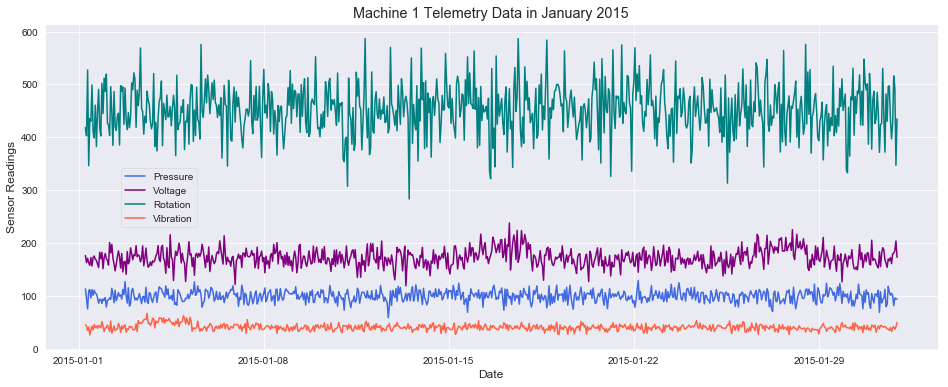

In [13]:
# plotting the first month of 'pressure' data from machine 1 for visualization, it should be noted the sensor values
    # have not been normalized to one another hence the scale difference
plt_df = sensorData.loc[(sensorData['machineID'] == 1) & 
                         (sensorData['datetime'] > pd.to_datetime('2014-12-31')) & 
                         (sensorData['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'pressure', 'volt', 'rotate', 'vibration']]
sns.set_style("darkgrid")
plt.figure(figsize=(16, 6))
plt.plot(plt_df['datetime'], plt_df['pressure'], color = 'royalblue', label = 'Pressure')
plt.plot(plt_df['datetime'], plt_df['volt'], color = 'purple', label = 'Voltage')
plt.plot(plt_df['datetime'], plt_df['rotate'], color = 'teal', label = 'Rotation')
plt.plot(plt_df['datetime'], plt_df['vibration'], color = 'tomato', label = 'Vibration')
plt.ylabel('Sensor Readings')
plt.xlabel('Date')
plt.title('Machine 1 Telemetry Data in January 2015')
plt.legend(bbox_to_anchor=(.08, .36))
#plt.legend()

Telemetry sensor data looks clean enough for the first pass, there are no missing values, the features have been converted to appropriate data types, and a quick visualization shows no extreme outliers in the data set.

#### Maintenance Data

This csv contains components that were changed due to scheduled maintenance and failures. At the same time, the failures are logged in a separate dataset, which will likely be more pertinent to our model. After cleaning all the datasets we can compare the scheduled changes and failures to the failureData csv and check for duplication, completeness, etc.

In [14]:
maintenanceData['datetime'] = pd.to_datetime(maintenanceData['datetime'], infer_datetime_format = True)
maintenanceData['comp'] = maintenanceData['comp'].astype('category')
maintenanceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null datetime64[ns]
machineID    3286 non-null int64
comp         3286 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 54.8 KB


In [15]:
maintenanceData.describe()

,machineID
count,3286.000000
mean,50.284236
std,28.914478
min,1.000000
25%,25.250000
50%,50.000000
75%,75.000000
max,100.000000


In [16]:
maintenanceData.sample(3)

,datetime,machineID,comp
309,2014-08-30 06:00:00,10,comp2
247,2014-11-28 06:00:00,8,comp1
1601,2015-04-15 06:00:00,49,comp4


In [17]:
# change 'datetime' to_datetime :)

# remove the begnning characters from 'comp' column and # change 'comp' to an integer
#maintenanceData['comp'] = maintenanceData['comp'].str[4:].astype(int)
#maintenanceData.info()

In [18]:
# check for duplicated rows by 'datetime' and 'machineID' to consolidate rows
maintenanceData.duplicated(['datetime', 'machineID', 'comp']).sum()

0

In [19]:
maintenanceData.drop_duplicates(subset=['datetime', 'machineID', 'comp'], inplace = True)
sum(maintenanceData.duplicated('datetime'))

2912

In [20]:
#This first concatenates your dataframe and the output of the get_dummies call, then it 
#groups the result according to the relevant columns, takes the sum of those columns among 
#those groups and then resets the index so you don't have to deal with a multi-index data frame
#maintenanceData = pd.concat([maintenanceData, pd.get_dummies(maintenanceData.comp)], 1).groupby(['datetime','machineID']).sum().reset_index()
#maintenanceData.drop(['comp'], axis=1, inplace=True)

In [21]:
maintenanceData.duplicated(['datetime', 'machineID']).sum()

758

In [22]:
#maintenanceData.columns = ['datetime', 'machineID', 'mComp_1', 'mComp_2', 'mComp_3', 'mComp_4']
#maintenanceData.sample(1)

Text(0,0.5,'Count')

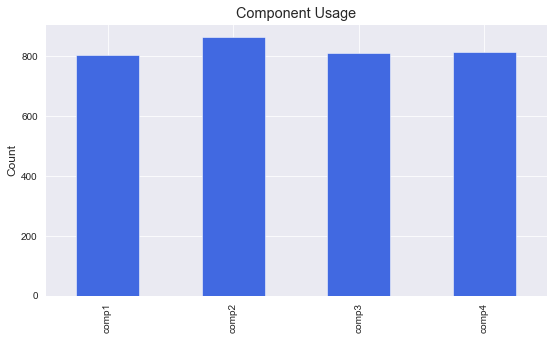

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
maintenanceData['comp'].value_counts().reindex(index = ['comp1', 'comp2', 'comp3', 'comp4'], axis = 1).plot(kind = 'bar', color = 'royalblue').set_title('Component Usage')
plt.ylabel('Count')

#### Origins Data

The vintage of each machine should add valuable correlation to the frequency of scheduled and failure component repairs.

In [24]:
originsData['model'] = originsData['model'].astype('category')
originsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
machineID    100 non-null int64
model        100 non-null category
age          100 non-null int64
dtypes: category(1), int64(2)
memory usage: 1.9 KB


In [25]:
# remove the begnning characters from 'model' column and change to integer data type
#originsData['model'] = originsData['model'].str[5:].astype(int)

In [26]:
originsData.shape

(100, 3)

In [27]:
originsData['age'].describe()

count    100.000000
mean      11.330000
std        5.856974
min        0.000000
25%        6.750000
50%       12.000000
75%       16.000000
max       20.000000
Name: age, dtype: float64

In [28]:
originsData.sample(5)

,machineID,model,age
21,22,model1,14
3,4,model3,7
88,89,model3,17
96,97,model2,14
5,6,model3,7


Text(0,0.5,'Count')

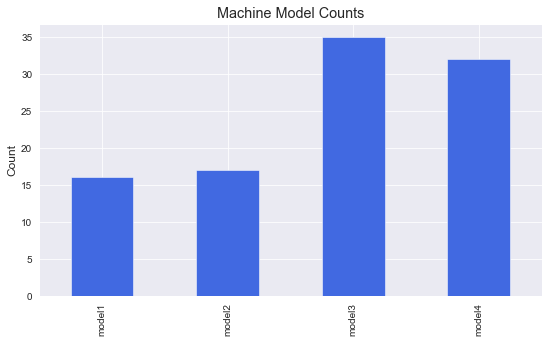

In [29]:
# quantity of each model
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
originsData.model.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Machine Model Counts')
plt.ylabel('Count')

Text(0,0.5,'Count')

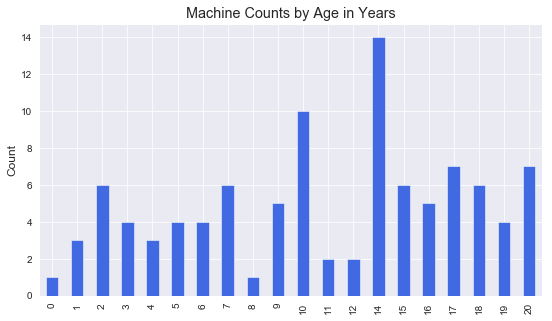

In [30]:
# quantity of each year
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
originsData.age.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Machine Counts by Age in Years')
plt.ylabel('Count')

#### Failure Data

This will obviously contain critical features to predicting future failures.

In [31]:
failureData['datetime'] = pd.to_datetime(failureData['datetime'], infer_datetime_format = True)
failureData['failure'] = failureData['failure'].astype('category')
failureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
datetime     761 non-null datetime64[ns]
machineID    761 non-null int64
failure      761 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.9 KB


In [32]:
failureData.sample(3)

,datetime,machineID,failure
517,2015-06-25 06:00:00,71,comp3
487,2015-09-28 06:00:00,67,comp1
384,2015-01-19 06:00:00,52,comp4


Text(0,0.5,'Count')

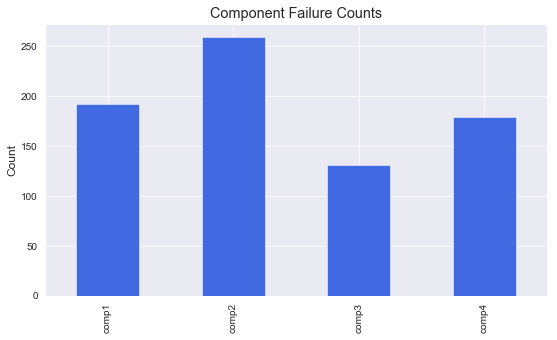

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
failureData.failure.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Component Failure Counts')
plt.ylabel('Count')

#### Error Data

We're going to see if there is a correlation between the errors generated on the machines, and eventual component maintenance / failure.

In [34]:
errorData['datetime'] = pd.to_datetime(errorData['datetime'], infer_datetime_format = True)
errorData['errorID'] = errorData['errorID'].astype('category')
errorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null datetime64[ns]
machineID    3919 non-null int64
errorID      3919 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 65.3 KB


In [35]:
errorData.sample(3)

,datetime,machineID,errorID
3175,2015-04-24 00:00:00,82,error4
2120,2015-08-24 21:00:00,55,error1
2552,2015-02-12 09:00:00,67,error3


Text(0,0.5,'Count')

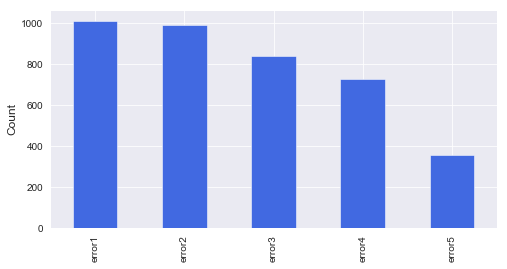

In [36]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errorData['errorID'].value_counts().plot(kind='bar', color = 'royalblue')
plt.ylabel('Count')

### 4. Feature Engineering, Label Construction, Merging, and Final Cleaning



#### Sensor Lag Windows
In the following, a rolling lag window is created for the sensor data based on a three hour window per the requirements in 'TRAIN/SLIT'. In order to create a lag window, the data must be supplied with a time stamp. Generally, sensor data is, which makes it easy to create these windows. The lag windows create a summary that we can view statistics on like mean, standard deviation, minimums, maximums, etc.

In [37]:
# means
temp = [] 
features = ['volt', 'rotate', 'pressure', 'vibration']
for column in features:
    temp.append(pd.pivot_table(sensorData, index = 'datetime', columns = 'machineID', values = column)
                .resample('3H', closed = 'left', how = 'mean', label = 'right').unstack())
sensorData3H_mean = pd.concat(temp, axis = 1)
sensorData3H_mean.columns = [n + '3H_mean' for n in features]
sensorData3H_mean.reset_index(inplace = True)

# standard deviations
temp = [] 
features = ['volt', 'rotate', 'pressure', 'vibration']
for column in features:
    temp.append(pd.pivot_table(sensorData, index = 'datetime', columns = 'machineID', values = column)
                .resample('3H', how = 'std', closed = 'left', label = 'right').unstack())
sensorData3H_std = pd.concat(temp, axis = 1)
sensorData3H_std.columns = [n + '3H_std' for n in features]
sensorData3H_std.reset_index(inplace = True)

In [38]:
sensorData3H_mean.head(3)

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405


In [39]:
sensorData3H_std.head(3)

,machineID,datetime,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304


In [40]:
# merge the new features into one df
sensorFeatures = pd.merge(sensorData3H_mean, sensorData3H_std, on = ['datetime', 'machineID']).dropna()
sensorFeatures.describe()

,machineID,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std
count,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164
std,28.866119,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278
25%,25.750000,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790
50%,50.500000,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955
75%,75.250000,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595


In [41]:
sensorFeatures.head()

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884


#### Error Lag Window
The errors data set also contains time stamps, so we can create a similar lag window for the errors. The notable difference is we want to sum the rows for each window as opposed to averaging.

In [42]:
#This first concatenates your dataframe and the output of the get_dummies call, then it 
#groups the result according to the relevant columns, takes the sum of those columns among 
#those groups and then resets the index so you don't have to deal with a multi-index data frame
errorFeatures = pd.concat([errorData, pd.get_dummies(errorData.errorID)], 1).groupby(['machineID', 'datetime']).sum().reset_index()
# rename the columns
errorFeatures.columns = ['machineID', 'datetime', 'error_1', 'error_2', 'error_3', 'error_4', 'error_5']
errorFeatures = errorFeatures.groupby(['machineID', 'datetime']).sum().reset_index()
# create time slots matching 'sensorData', which is the most complete, and fill empty cells with 0.
errorFeatures = sensorData[['datetime', 'machineID']].merge(errorFeatures, on=['machineID', 'datetime'], how='left').fillna(0.0)
errorFeatures.describe()

,machineID,error_1,error_2,error_3,error_4,error_5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
errorFeatures.head()

,datetime,machineID,error_1,error_2,error_3,error_4,error_5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [44]:
temp = []
features = ['error_%d' % i for i in range(1,6)]
for column in features:
    temp.append(pd.pivot_table(errorFeatures, index='datetime', 
                               columns='machineID', values=column).rolling(window = 24, 
                                                                       center = False).sum().resample('3H', 
                                                                                                      closed='left', 
                                                                                                      label='right', 
                                                                                                      how='first').unstack())
# create time slots matching 'sensorData', which is the most complete, and fill empty cells with 0.
errorFeatures = sensorData[['datetime', 'machineID']].merge(errorFeatures, on=['machineID', 'datetime'], how='left').fillna(0.0)
errorFeatures = pd.concat(temp, axis = 1)
errorFeatures.columns = [n + '_count' for n in features]
errorFeatures.reset_index(inplace = True)
errorFeatures = errorFeatures.dropna()
errorFeatures.describe()

,machineID,error_1_count,error_2_count,error_3_count,error_4_count,error_5_count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [45]:
errorFeatures.head(5)

,machineID,datetime,error_1_count,error_2_count,error_3_count,error_4_count,error_5_count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


#### Running 'Days Since Replacement'
The maintenance data set in this problem should possess critical informaiton towards predicting component failures. Considering we're trying to predict a future failure, a feature that tracked how long it's been since maintenance was last performed on that component would likely be valuable.

In [46]:
# create a column for each error type
compFeatures = pd.get_dummies(maintenanceData.set_index('datetime')).reset_index()
compFeatures.columns = ['datetime', 'machineID', 'comp_1', 'comp_2', 'comp_3', 'comp_4']

# combine repairs for a given machine in a given hour
compFeatures = compFeatures.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
compFeatures = sensorData[['datetime', 'machineID']].merge(compFeatures,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp_1', 'comp_2', 'comp_3', 'comp_4']
for comp in components:
    # convert indicator to most recent date of component change
    compFeatures.loc[compFeatures[comp] < 1, comp] = None
    compFeatures.loc[-compFeatures[comp].isnull(), comp] = compFeatures.loc[-compFeatures[comp].isnull(), 'datetime']
   
    # forward-fill the most-recent date of component change
    compFeatures[comp] = compFeatures[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
compFeatures = compFeatures.loc[compFeatures['datetime'] > pd.to_datetime('2015-01-01')]
# convert 'datetime' column from np to standard? not having this line was a huge problem
compFeatures['datetime'] = pd.to_datetime(compFeatures['datetime'], infer_datetime_format = True)
# replace dates of most recent component change with days since most recent component change
for comp in components:
    compFeatures[comp] = pd.to_datetime(compFeatures[comp], infer_datetime_format = True)
    compFeatures[comp] = (compFeatures['datetime'] - compFeatures[comp]) / np.timedelta64(1, 'D')


compFeatures.describe()
#compFeatures = pd.read_csv('compFeatures')

,machineID,comp_1,comp_2,comp_3,comp_4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [47]:
# rename the columns
compFeatures = compFeatures.rename(columns={'comp_1':'comp_1_daySince', 
                            'comp_2':'comp_2_daySince', 
                            'comp_3':'Comp_3_daySince', 
                            'comp_4':'comp_4_daySince'})
# drop the repeated index column
#compFeatures.drop(['Unnamed: 0'], axis=1, inplace=True)
# format 'datetime'
compFeatures['datetime'] = pd.to_datetime(compFeatures['datetime'], infer_datetime_format = True)
compFeatures.head()

,datetime,machineID,comp_1_daySince,comp_2_daySince,Comp_3_daySince,comp_4_daySince
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


#### Merger

In [48]:
# combine all the data sets
DataFrames = ['sensorData', 'sensorFeatures', 'errorData', 'errorFeatures', 
              'maintenanceData', 'compFeatures', 'originsData', 'failureData']

#singleDF = sensorData.merge(sensorFeatures, on = ['datetime', 'machineID'], how = 'left')
#singleDF = singleDF.merge(errorData, on = ['datetime', 'machineID'], how = 'left')
#singleDF = singleDF.merge(errorFeatures, on = ['datetime', 'machineID'], how = 'left')
#singleDF = singleDF.merge(maintenanceData, on = ['datetime', 'machineID'], how = 'left')
#singleDF = singleDF.merge(compFeatures, on = ['datetime', 'machineID'], how = 'left')
singleDF = sensorFeatures.merge(compFeatures, on = ['datetime', 'machineID'], how = 'left')
singleDF = singleDF.merge(errorFeatures, on = ['datetime', 'machineID'], how = 'left')
singleDF = singleDF.merge(originsData, on = ['machineID'], how = 'left')
#singleDF = singleDF.merge(failureData, on = ['datetime', 'machineID'], how = 'left')

In [49]:
singleDF.head()

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std,comp_1_daySince,comp_2_daySince,Comp_3_daySince,comp_4_daySince,error_1_count,error_2_count,error_3_count,error_4_count,error_5_count,model,age
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,19.125,214.125,154.125,169.125,NaN,NaN,NaN,NaN,NaN,model3,18
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,19.250,214.250,154.250,169.250,NaN,NaN,NaN,NaN,NaN,model3,18
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,19.375,214.375,154.375,169.375,NaN,NaN,NaN,NaN,NaN,model3,18
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,19.500,214.500,154.500,169.500,NaN,NaN,NaN,NaN,NaN,model3,18
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,19.625,214.625,154.625,169.625,NaN,NaN,NaN,NaN,NaN,model3,18


#### Label Selection

In [50]:
singleDF.to_csv('singleDF')